In [ ]:
using ITensors, ITensorMPS, PythonPlot

# Global variables to store results
global C1zz = nothing
global C2zz = nothing
global C3zz = nothing
global L = 40

let
    # Create L Spin-1/2 Indices
    sites = siteinds("S=1/2", L)

    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
    # Boundary terms
    osI -= "X", L
    osI -= "Z", L, "Z", 1
    HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
    # Boundary terms
    os3 += "X", L - 1, "Z", L, "Z", 1
    os3 += "X", L, "Z", 1, "Z", 2
    os3 += "Z", L - 1, "Z", L, "X", 1
    os3 += "Z", L, "Z", 1, "X", 2
    H3 = MPO(os3, sites)

    # Coupling coefficients for Exact G.S.
        lambdaI = 1
        lambda3 = 1
    
    #= Coupling coefficients for TCI such that lambda3 / lambdaI = 0.856
        lambdaI = 0.759685
        lambda3 = 0.650291
    =#

    # Adding the energy offset E0 to just one site
    EO = L * (lambdaI^2 + lambda3^2) / lambda3
    
    osEO = OpSum()
        osEO += EO, "Id", 1
    E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
    H = 2 * lambdaI * HI + lambda3 * H3 + E0

    # Create an initial random matrix product state
    psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
    nsweeps = 10
    maxdim = [10, 33, 66, 133, 200]
    mindim = [10, 22, 33, 66, 133]
    cutoff = 1.0e-10

    println("Maxdim per sweep: ", maxdim)
    println("Mindim per sweep: ", mindim)
    println()
    
    # Run the DMRG algorithm to find the lowest 4 energy eigenstates and their energies.
    psi = [MPS() for i = 1:4]
    energies = zeros(4)

    energies[1], psi[1] = dmrg(H, psi0; nsweeps, mindim, maxdim, cutoff)
    for i = 2:4
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, mindim, maxdim, cutoff, weight = 100)
    end

    # Sort the three lowest energy states and the excited state
    sorted_indices = sortperm(energies)
    ground_state_indices = sorted_indices[1:3]
    excited_state_index = sorted_indices[4]

    println("\nAll energies from low to high:")
    for (i, idx) in enumerate(sorted_indices)
        if i <= 3
            println("Ground state $i = $(energies[idx]) (state $idx)")
        else
            println("Excited state = $(energies[idx]) (state $idx)")
        end
    end
    println()
    
    # Overlap between all states
    println("Ground state normalizations:")
    for i in 1:3
        idx_i = ground_state_indices[i]
        println("<psi$(idx_i)|psi$(idx_i)> = $(inner(psi[idx_i], psi[idx_i]))")
    end
    println("\nExcited state normalization:")
    println("<psi$(excited_state_index)|psi$(excited_state_index)> = $(inner(psi[excited_state_index], psi[excited_state_index]))")
    println()
    
    println("Overlap between ground states:")
    for i in 1:3
        for j in (i+1):3
            idx_i = ground_state_indices[i]
            idx_j = ground_state_indices[j]
            println("<psi$(idx_i)|psi$(idx_j)> = $(inner(psi[idx_i], psi[idx_j]))")
        end
    end
    
    println("\nOverlap between excited state and ground states:")
    for i in 1:3
        idx_i = ground_state_indices[i]
        println("<psi$(idx_i)|psi$(excited_state_index)> = $(inner(psi[idx_i], psi[excited_state_index]))")
    end
    println()

    # Compute Z-Z correlations matrices for all states
    global C1zz = correlation_matrix(psi[ground_state_indices[1]], "Z", "Z")
    global C2zz = correlation_matrix(psi[ground_state_indices[2]], "Z", "Z")
    global C3zz = correlation_matrix(psi[ground_state_indices[3]], "Z", "Z")
    global C4zz = correlation_matrix(psi[excited_state_index], "Z", "Z")

    # Store the indices so the plotting cell knows which states these correspond to
    global ground_state_labels = ground_state_indices
    global excited_state_label = excited_state_index

    nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]
Mindim per sweep: [10, 22, 33, 66, 133]

After sweep 1 energy=3.4292415772357625  maxlinkdim=4 maxerr=2.37E-16 time=0.055
After sweep 2 energy=0.017781884991506607  maxlinkdim=16 maxerr=5.23E-16 time=0.118
After sweep 1 energy=3.4292415772357625  maxlinkdim=4 maxerr=2.37E-16 time=0.055
After sweep 2 energy=0.017781884991506607  maxlinkdim=16 maxerr=5.23E-16 time=0.118
After sweep 3 energy=2.7766194257594634e-5  maxlinkdim=33 maxerr=1.00E-12 time=0.361
After sweep 3 energy=2.7766194257594634e-5  maxlinkdim=33 maxerr=1.00E-12 time=0.361
After sweep 4 energy=4.646624381615863e-7  maxlinkdim=66 maxerr=3.80E-15 time=1.690
After sweep 4 energy=4.646624381615863e-7  maxlinkdim=66 maxerr=3.80E-15 time=1.690
After sweep 5 energy=8.405185353422051e-9  maxlinkdim=133 maxerr=1.01E-15 time=6.218
After sweep 5 energy=8.405185353422051e-9  maxlinkdim=133 maxerr=1.01E-15 time=6.218
After sweep 6 energy=1.497362234204047e-10  maxlinkdim=133 maxerr=9.16E-16 time=

Max and Min Correlations for Ground States:
State 1: 1.9410903974645467e-15 and 6.4555041006777926e-21
State 2: 0.9999999999797871 and 0.9999999891508564
State 3: 0.9999999967228629 and 0.9999994136022501

Max and Min Correlations for Excited State:
State 4: 0.7935305598760887 and 0.12689034835903187



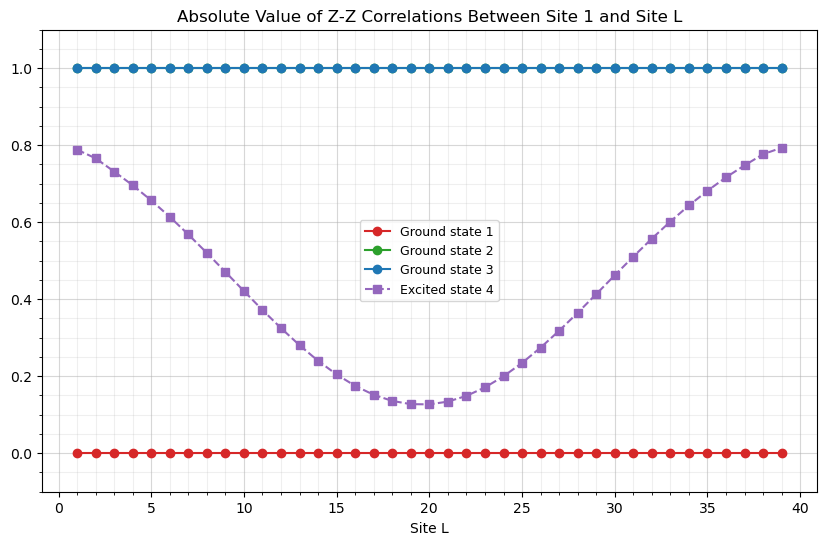

In [ ]:
using PythonPlot

# Get the absolute values of correlations for all states
abs_C1zz = abs.(C1zz[1, 2:end])
abs_C2zz = abs.(C2zz[1, 2:end])
abs_C3zz = abs.(C3zz[1, 2:end])
abs_C4zz = abs.(C4zz[1, 2:end])  # Excited state

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
x1 = collect(1:length(abs_C1zz))
plot(x1, abs_C1zz, marker="o", linestyle="-", color="tab:red", linewidth=1.5, 
     label="Ground state $(ground_state_labels[1])")

x2 = collect(1:length(abs_C2zz))
plot(x2, abs_C2zz, marker="o", linestyle="-", color="tab:green", linewidth=1.5,
     label="Ground state $(ground_state_labels[2])")

x3 = collect(1:length(abs_C3zz))
plot(x3, abs_C3zz, marker="o", linestyle="-", color="tab:blue", linewidth=1.5,
     label="Ground state $(ground_state_labels[3])")

# Plot the Z-Z correlations for excited state
x4 = collect(1:length(abs_C4zz))
plot(x4, abs_C4zz, marker="s", linestyle="--", color="tab:purple", linewidth=1.5,
     label="Excited state $(excited_state_label)")

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
    
# Adjusting graph
ymax = max(maximum(abs_C1zz), maximum(abs_C2zz), maximum(abs_C3zz), maximum(abs_C4zz))
ymin = min(minimum(abs_C1zz), minimum(abs_C2zz), minimum(abs_C3zz), minimum(abs_C4zz))
ylim(ymin - 0.1, ymax + 0.1)
minorticks_on()
    
# Print max and min values for reference, including which original state they came from
println("Max and Min Correlations for Ground States:")
println("State $(ground_state_labels[1]): ", maximum(abs_C1zz), " and ", minimum(abs_C1zz))
println("State $(ground_state_labels[2]): ", maximum(abs_C2zz), " and ", minimum(abs_C2zz))
println("State $(ground_state_labels[3]): ", maximum(abs_C3zz), " and ", minimum(abs_C3zz))
println("\nMax and Min Correlations for Excited State:")
println("State $(excited_state_label): ", maximum(abs_C4zz), " and ", minimum(abs_C4zz))
println()